In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
import json
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [2]:
BASE_DIR = "/kaggle/input/coco-2017-dataset/coco2017"
WORKING_DIR = "/kaggle/working/"
FEATURE_DIR = os.path.join(WORKING_DIR, "Feature")
MODEL_DIR = os.path.join(WORKING_DIR, "Model")

# Load image feature

In [3]:
# load feature features extracted from training set
with open('/kaggle/input/feature-train/features_train.pkl', 'rb') as file:
    img_train_features = pickle.load(file)

#  load feature features extracted from validating set
with open('/kaggle/input/features-val/features_val.pkl', 'rb') as file:
    img_val_features = pickle.load(file)

# Load caption data

In [4]:
# Train data
with open("/kaggle/input/caption-coco2017-tqm/CoCo_transform_train2017.json", 'r') as file:
    mapping_train_origin = json.load(file)
mapping_train = dict()

for key in mapping_train_origin:
    mapping_train[key.split('.')[0]] = mapping_train_origin[key]

len(mapping_train)

118287

In [5]:
# validation data
with open("/kaggle/input/caption-coco2017-tqm/CoCo_transform_val2017.json", 'r') as file:
    mapping_val_origin = json.load(file)
mapping_val = dict()

for key in mapping_val_origin:
    mapping_val[key.split('.')[0]] = mapping_val_origin[key]

len(mapping_val)

5000

# Preprocessing text data

In [6]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'seqstart ' + " ".join([word for word in caption.split() if len(word)>1]) + ' seqend'
            captions[i] = caption
            

In [7]:
# Preprocessing text
clean(mapping_train)
clean(mapping_val)

In [8]:
all_captions = []
for key in mapping_train:
    for caption in mapping_train[key]:
        all_captions.append(caption)

In [9]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [10]:
# Create data generator
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                
                X1, X2, y = list(), list(), list()
                n = 0
                    

# Load model

In [11]:
max_length = max(len(caption.split()) for caption in all_captions)

/kaggle/input/model-check-point/best_model.keras


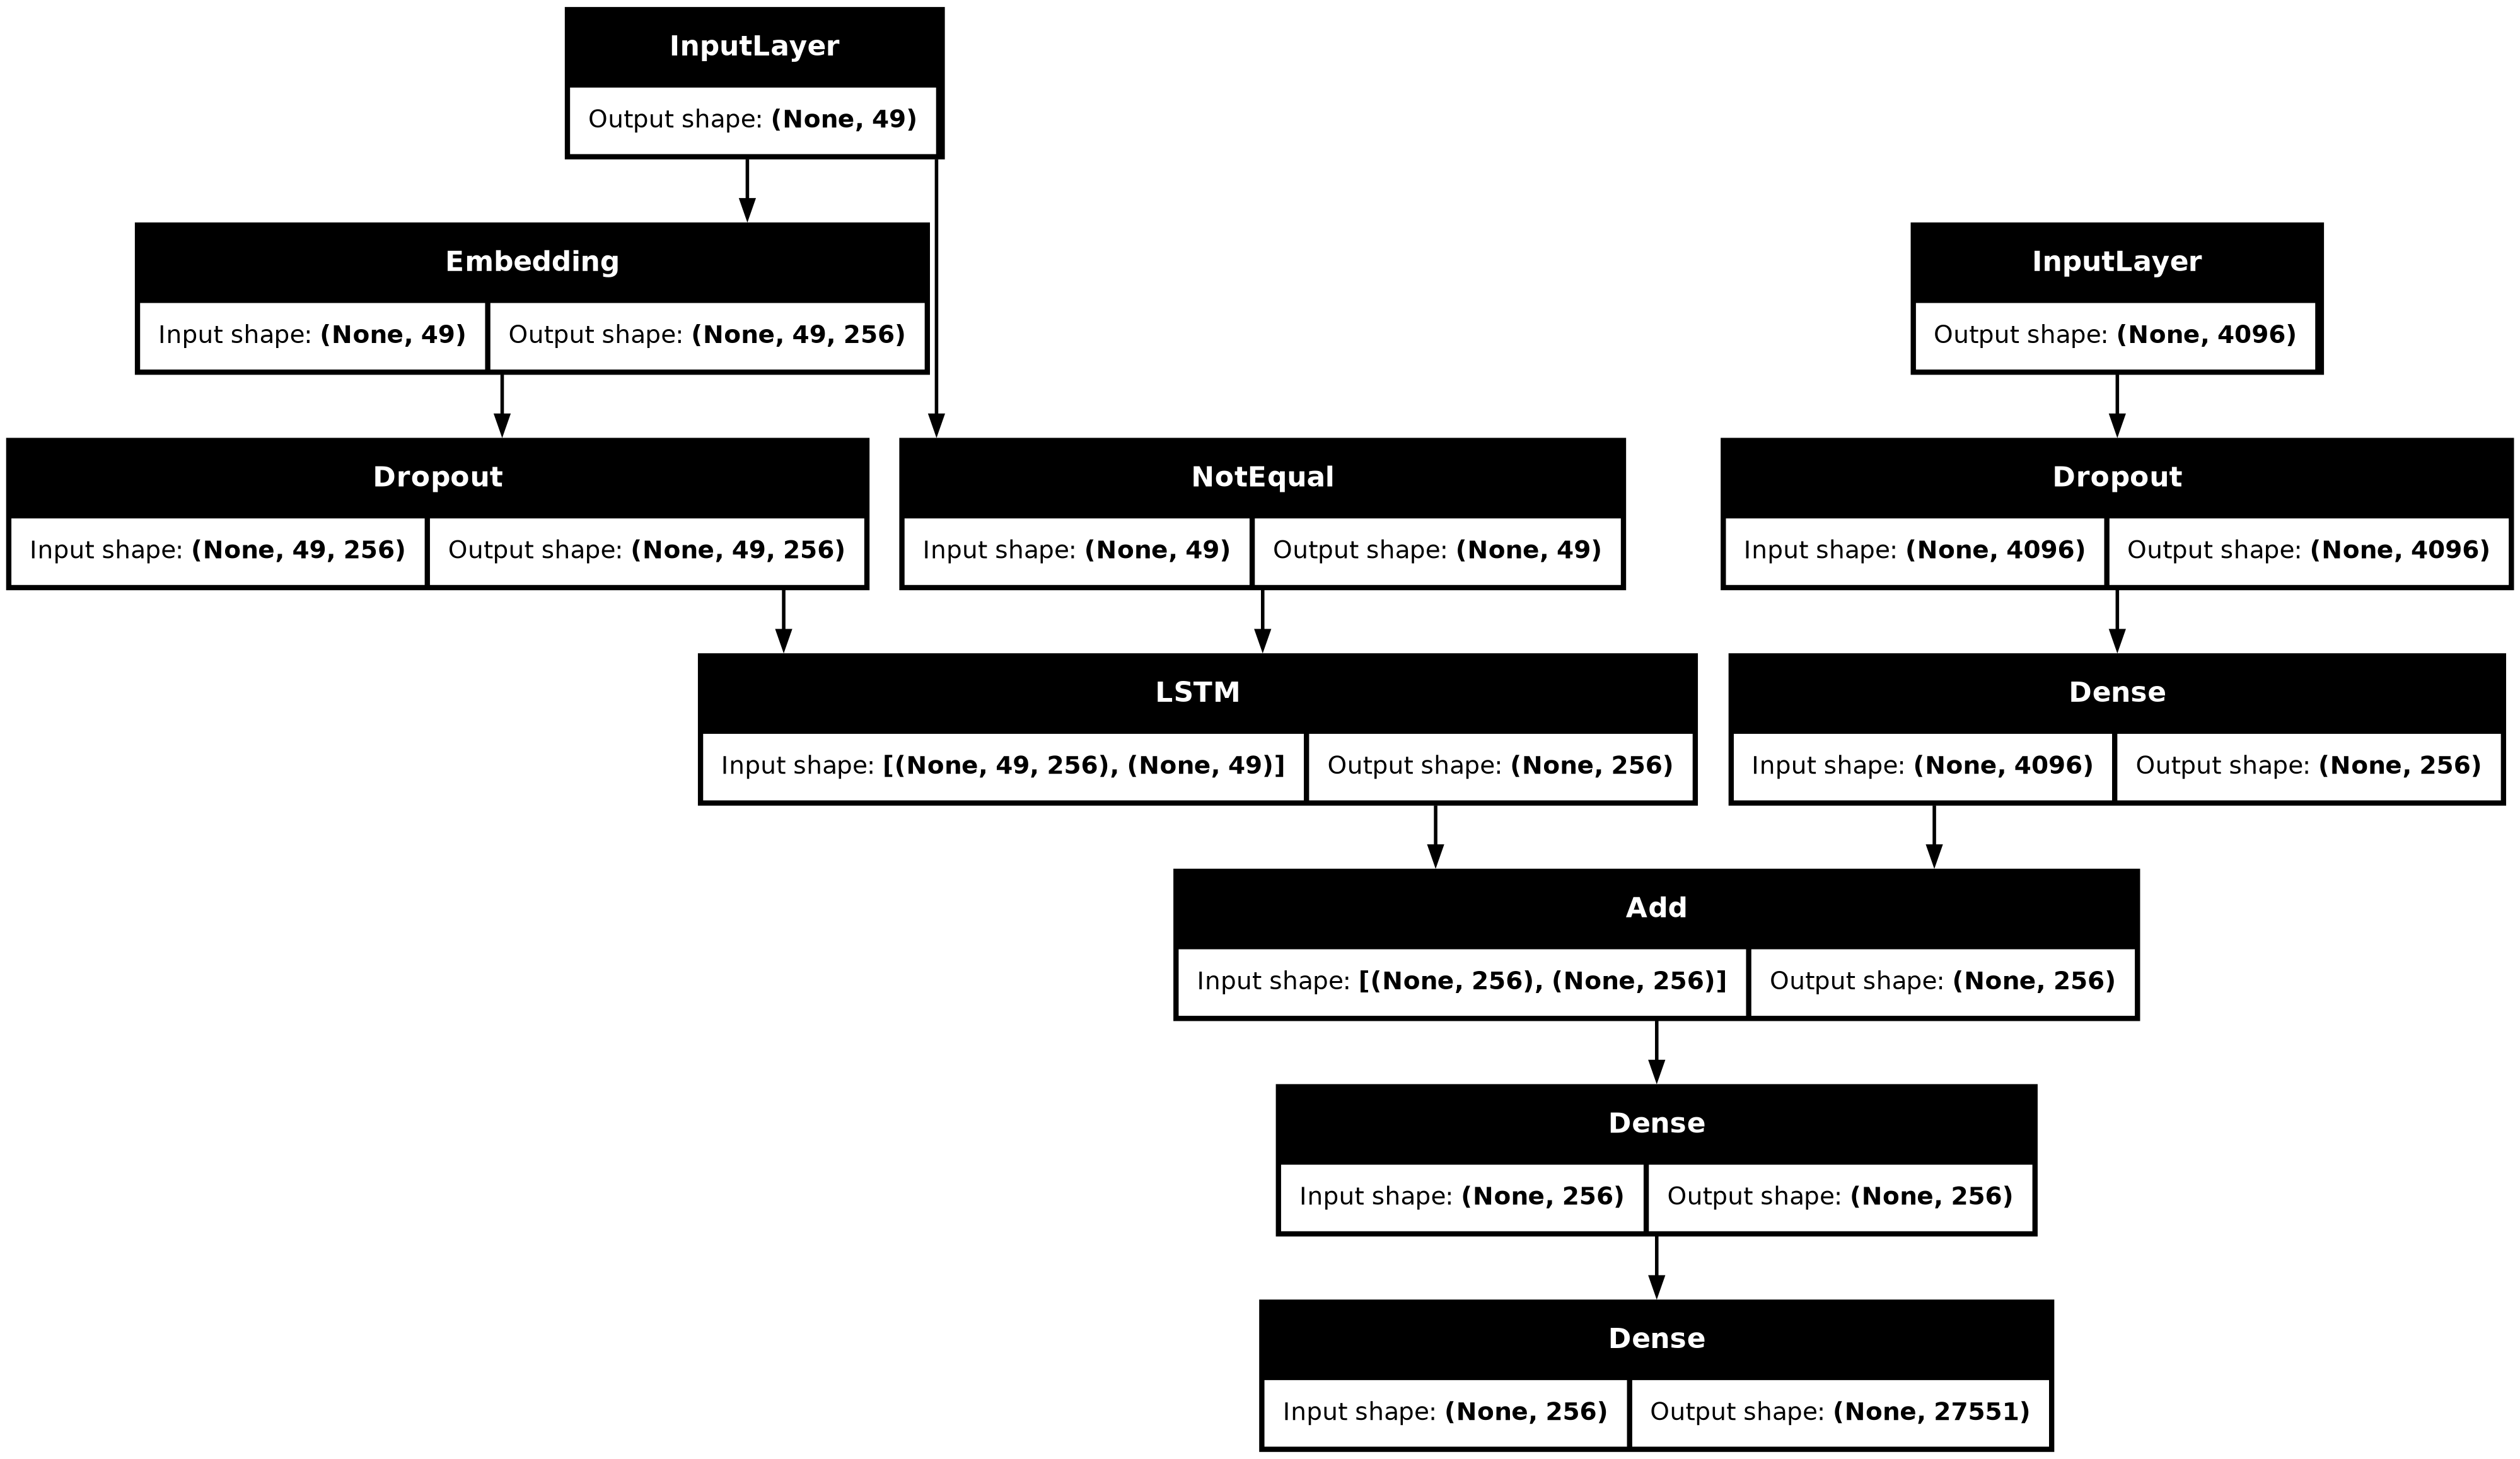

In [12]:
# load the model
model_dir = "/kaggle/input/model-check-point/best_model.keras"
print(model_dir)
model = load_model(model_dir)
model = model
plot_model(model, show_shapes=True)

# Generating caption for image

In [13]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [14]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    image = image
    # add start tag for generation process
    in_text = 'seqstart'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'seqend':
            break
    return in_text

# Visualization

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
def visualize_the_result(image_name, mapping, features):
    # Load the image
    image_name = image_name
    image_id = image_name.split('.')[0]
    image_path = os.path.join(BASE_DIR, "val2017", image_name)
    image = Image.open(image_path)
    captions = mapping[image_id]
    # print("----------------------Actual----------------------")
    # for caption in captions:
    #     len_caption = len(caption)
        # print(caption[8:len_caption-7].rstrip(".").strip(" "))
    
    # Predicted caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    # print("--------------------Predicted--------------------")

    len_pred = len(y_pred)
    y_pred = y_pred[9:len_pred-7].strip(" ")
    # plt.imshow(image)
    
    return y_pred
    # caption = visualize_the_result('000000000285.jpg', mapping_val, img_val_features)


**Evaluate on Validation Dataset**

In [16]:
#Format the validation dataset into COCO dataset
import json
from collections import defaultdict

#Load Dataset
input_file = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json'

with open(input_file, "r") as file:
    data = json.load(file)
print(len(data['images']))

5000


In [17]:
# Extract data
info = data["info"]
licenses = data["licenses"]
images = data["images"]
annotations = data["annotations"]

def split_data(images, annotations, num_splits=5):
    split_images = [[] for _ in range(num_splits)]
    split_annotations = [[] for _ in range(num_splits)]

    total_images = len(images)
    images_per_split = total_images // num_splits

    image_id_to_split = {}
    for idx, img in enumerate(images):
        split_index = idx // images_per_split
        if split_index >= num_splits:  
            split_index = num_splits - 1
        split_images[split_index].append(img)
        image_id_to_split[img["id"]] = split_index

    for ann in annotations:
        image_id = ann["image_id"]
        if image_id in image_id_to_split:
            split_index = image_id_to_split[image_id]
            split_annotations[split_index].append(ann)
    
    return split_images, split_annotations

split_images, split_annotations = split_data(images, annotations)

for i in range(5):
    output_data = {
        "info": info,
        "licenses": licenses,
        "images": split_images[i],
        "annotations": split_annotations[i]
    }
    output_file = f"output_{i*1000}_{(i+1)*1000}.json"
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(output_data, f, indent=4, ensure_ascii=False)
    print(f"Saved: {output_file}")

Saved: output_0_1000.json
Saved: output_1000_2000.json
Saved: output_2000_3000.json
Saved: output_3000_4000.json
Saved: output_4000_5000.json


**CHECK**

In [18]:
def check_annotations(file_paths):
    for file_path in file_paths:
        with open(file_path, "r") as f:
            data = json.load(f)
        
        images = data["images"]
        annotations = data["annotations"]

        image_id_count = {}
        for ann in annotations:
            image_id = ann["image_id"]
            if image_id not in image_id_count:
                image_id_count[image_id] = 0
            image_id_count[image_id] += 1

        print(f"Checking file: {file_path}")
        for img in images:
            image_id = img["id"]
            count = image_id_count.get(image_id, 0)
            if count != 5:
                print(f"Image ID {image_id} does not have 5 annotations. Found: {count}")
        print("Check complete!\n")

file_paths = [
    "/kaggle/working/output_0_1000.json",
    "/kaggle/working/output_1000_2000.json",
    "/kaggle/working/output_2000_3000.json",
    "/kaggle/working/output_3000_4000.json",
    "/kaggle/working/output_4000_5000.json",
]
check_annotations(file_paths)

Checking file: /kaggle/working/output_0_1000.json
Image ID 96493 does not have 5 annotations. Found: 6
Image ID 215259 does not have 5 annotations. Found: 6
Image ID 163057 does not have 5 annotations. Found: 6
Image ID 289516 does not have 5 annotations. Found: 6
Image ID 165257 does not have 5 annotations. Found: 6
Check complete!

Checking file: /kaggle/working/output_1000_2000.json
Image ID 431896 does not have 5 annotations. Found: 7
Image ID 434459 does not have 5 annotations. Found: 6
Image ID 190841 does not have 5 annotations. Found: 6
Image ID 328030 does not have 5 annotations. Found: 6
Check complete!

Checking file: /kaggle/working/output_2000_3000.json
Check complete!

Checking file: /kaggle/working/output_3000_4000.json
Image ID 449312 does not have 5 annotations. Found: 6
Image ID 2923 does not have 5 annotations. Found: 6
Check complete!

Checking file: /kaggle/working/output_4000_5000.json
Image ID 545958 does not have 5 annotations. Found: 6
Image ID 38070 does not h

In [19]:
!git clone https://github.com/salaniz/pycocoevalcap.git

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'pycocoevalcap'...
remote: Enumerating objects: 821, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 821 (delta 5), reused 15 (delta 4), pack-reused 797 (from 1)
Receiving objects: 100% (821/821), 130.06 MiB | 44.44 MiB/s, done.
Resolving deltas: 100% (424/424), done.


In [20]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 8.2 MB/s eta 0:00:00:00:01


In [21]:
import sys
sys.path.append('/kaggle/working/coco-caption/pycocoevalcap/tokenizer')

In [22]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

def evaluation(file_path, output_predict_file, coco_gt_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    
    # Load images and annotations
    images = data.get("images", [])
    annotations = data.get("annotations", [])
    
    image_id_to_filename = {img["id"]: img["file_name"] for img in images}
    results = [] 
    processed_image_ids = set()  
    
    # Generate predictions for unique images
    for ann in annotations:
        image_id = ann["image_id"]
        
        if image_id in processed_image_ids:
            continue
        
        processed_image_ids.add(image_id)
        
        file_name = image_id_to_filename[image_id]
        caption = visualize_the_result(file_name, mapping_val, img_val_features)  # Function to generate captions
        
        results.append({
            "image_id": image_id,
            "caption": caption
        })
    
    # Save the prediction results to JSON
    with open(output_predict_file, "w") as f:
        json.dump(results, f)
    
    # Load ground truth and predictions
    coco = COCO(coco_gt_path)
    coco_result = coco.loadRes(output_predict_file)
    
    # Evaluate results using COCOEvalCap
    coco_eval = COCOEvalCap(coco, coco_result)
    coco_eval.params['image_id'] = coco_result.getImgIds()
    coco_eval.evaluate()
    
    return coco_eval.eval  # Return evaluation results as a dictionary


In [ ]:

output_predict_file = "/kaggle/working/predict_file.json"
coco_gt_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json"

average_metrics = {}
num_files = len(file_paths)

for count, path in enumerate(file_paths, start = 1):
    print(f"Test {count}:")
    results = evaluation(path, output_predict_file, coco_gt_path)
    
    # Print metrics for the current test
    for metric, score in results.items():
        print(f"{metric}: {score:.3f}")
        if metric not in average_metrics:
            average_metrics[metric] = 0
        average_metrics[metric] += score
    
    print("**********\n")

# Calculate and print average metrics
print("Average Results:")
for metric, total_score in average_metrics.items():
    avg_score = total_score / num_files
    print(f"{metric}: {avg_score:.3f}")


Test 1:
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 61766 tokens at 247376.61 tokens per second.
PTBTokenizer tokenized 8487 tokens at 63745.28 tokens per second.


setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 7488, 'reflen': 8767, 'guess': [7488, 6488, 5488, 4488], 'correct': [4137, 1247, 318, 71]}
ratio: 0.8541120109500565
Bleu_1: 0.466
Bleu_2: 0.275
Bleu_3: 0.154
Bleu_4: 0.084
computing METEOR score...
METEOR: 0.161
computing Rouge score...
ROUGE_L: 0.336
computing CIDEr score...
CIDEr: 0.461
computing SPICE score...


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.3 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.6 sec].
Loading classif

SPICE evaluation took: 1.776 min
SPICE: 0.128
Bleu_1: 0.466
Bleu_2: 0.275
Bleu_3: 0.154
Bleu_4: 0.084
METEOR: 0.161
ROUGE_L: 0.336
CIDEr: 0.461
SPICE: 0.128
**********

Test 2:
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 61335 tokens at 291831.39 tokens per second.
PTBTokenizer tokenized 8471 tokens at 66591.43 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 7472, 'reflen': 8709, 'guess': [7472, 6472, 5472, 4472], 'correct': [4060, 1203, 310, 82]}
ratio: 0.8579630267538342
Bleu_1: 0.460
Bleu_2: 0.269
Bleu_3: 0.152
Bleu_4: 0.086
computing METEOR score...
METEOR: 0.161
computing Rouge score...
ROUGE_L: 0.327
computing CIDEr score...
CIDEr: 0.479
computing SPICE score...


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.3 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classif

SPICE evaluation took: 1.743 min
SPICE: 0.125
Bleu_1: 0.460
Bleu_2: 0.269
Bleu_3: 0.152
Bleu_4: 0.086
METEOR: 0.161
ROUGE_L: 0.327
CIDEr: 0.479
SPICE: 0.125
**********

Test 3:
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 61141 tokens at 275954.07 tokens per second.
PTBTokenizer tokenized 8573 tokens at 65116.87 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 7574, 'reflen': 8705, 'guess': [7574, 6574, 5574, 4574], 'correct': [4151, 1262, 348, 81]}
ratio: 0.8700746697299402
Bleu_1: 0.472
Bleu_2: 0.279
Bleu_3: 0.161
Bleu_4: 0.089
computing METEOR score...
METEOR: 0.161
computing Rouge score...
ROUGE_L: 0.335
computing CIDEr score...
CIDEr: 0.471
computing SPICE score...


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.4 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classif

SPICE evaluation took: 1.698 min
SPICE: 0.128
Bleu_1: 0.472
Bleu_2: 0.279
Bleu_3: 0.161
Bleu_4: 0.089
METEOR: 0.161
ROUGE_L: 0.335
CIDEr: 0.471
SPICE: 0.128
**********

Test 4:
